# Shark Species Classifier

For this solution we're goging to use transfer learning to retrain a EfficienNetB1 model to classify images of sharks.

## Data Preperation

Fist, download the shark species Dataset from Kaggle.

[Shark Dataset Files](https://www.kaggle.com/larusso94/shark-species/download)

Now lets copy the file from our Downloads directory into the current directory.  

In [6]:
!cp ~/Downloads/archive.zip .

Unzip the file and a "sharks" directory should appear.

In [ ]:
!unzip archive.zip
# Now remove the zip
!rm archive.zip

## Setting up BoonSDK

We're going to use a BoonSDK command line tool called "boonctl", but in order to do that we're going to need
to set our API key file as an environment variable.  Be sure your API key is stored in a file called "apikey.json"
and it's in the current directory.

In [4]:
%env BOONAI_APIKEY_FILE = apikey.json

env: BOONAI_APIKEY_FILE=apikey.json


In [2]:
import boonsdk
app = boonsdk.app_from_env()

Now we're going to the boonctl command line tool to look at the datadata and do 2 things:

   * Create a sharks dataset in BoonAI
   * Upload and pre-label the bull and whale assets.
   
What boonctl is doing in this case is looking for a directory structure <dataset name>/<label name>/images and just taking the names of the directories and using them as needed.
    
The command line args:
   * classification: Indicates we're creating a dataset for image classification
   * sharks: The directory to look in for files.
   * -q : Don't ask questions, just assume yes to all questions
   * -l : The sub directories to import. The directory name will be used as a label.

In [3]:
! boonctl datasets import classification sharks -q -l bull

Detected Name: sharks (exists: True)
Detected Labels: ['hammerhead', 'bull', 'nurse', 'mako', 'blue', 'lemon', 'basking', 'tiger', 'whale', 'whitetip', 'thresher', 'sand tiger', 'white', 'blacktip']
Ok? (ctr-c to abort)
Importing 106 "bull" assets. Train: 95 Test: 11


At this point grab some coffee as your images are uploaded and processed, this can take 5+ minutes as BoonAI exacts and generates metadata for each image.  Once the images are imported we can visualize them here.


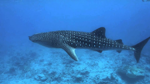
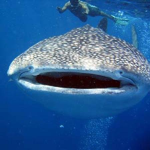
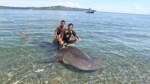
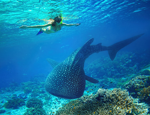
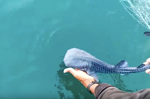
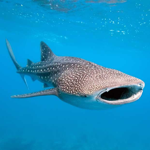
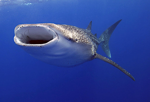
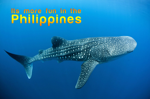
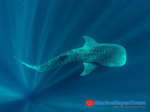
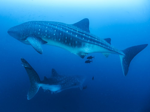
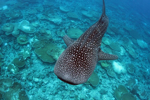
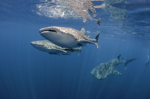
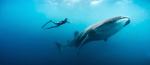
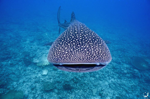
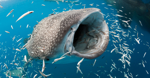
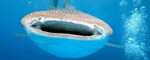
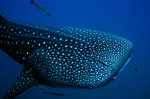
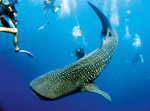
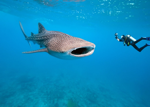
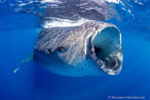


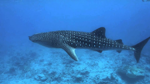
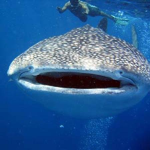
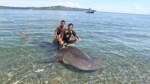
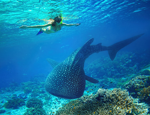
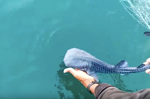
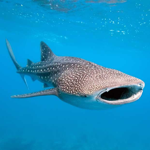
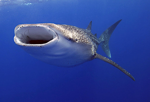
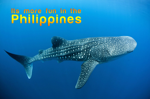
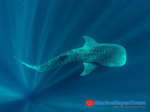
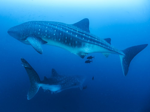
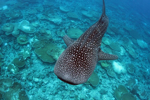
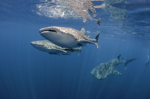
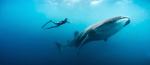
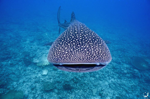
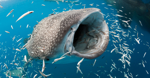
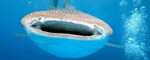
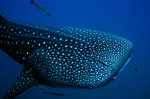
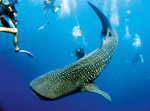
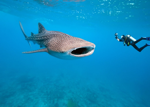
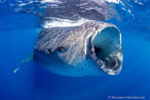

In [10]:
import ipyplot
from PIL import Image

ds = app.datasets.get_dataset("sharks")

# show a sample of our shark pics
images = []
labels = []
search = {"training_set": {"datasetId": ds.id}, "size": 20}
for asset in app.assets.search(search):
    thumbnail = asset.get_files(category="web-proxy")[0]
    images.append(Image.open(app.assets.download_file(thumbnail)))
    labels.append(asset.get_attr("labels")[0]['label'])

ipyplot.plot_images(images, labels, max_images=20, img_width=150)


## Creating and Training the Model

Now lets configure a model to train.  What we're doing here is grabbing a reference to the shark dataset created by the boonctl tool. Then creating Tensorflow Classifier model and linking the shark Dataset to it.

In [3]:
model = app.models.create_model("shark-species", boonsdk.ModelType.TF_CLASSIFIER, dataset=ds)

Now train the model which returns a training job.  We'll use the wait_on_job() function to wait
until training completes.

In [16]:
training_job = app.models.train_model(app.models.get_model("shark-species"))

In [18]:
app.jobs.wait_on_job(training_job)

True

## Testing the Model

Now that we've trained our model we have to test it.  Incidently you can combine traiing and testing into a single step, however it's good to know how to just run a test in case you end up labeling a few more test assets.

In [3]:
test_job = app.models.test_model(app.models.get_model('shark-species'))
app.jobs.wait_on_job(test_job)

True

## Viewing Model Test Results

Currently the best way to see the results of our test is to use BoonAI Console UI.  Once the test job is done, navigate to the custom model
to view the confusin matrix.  Eventually we'll be able to view the Matrix in a notebook.

We achieved 100% accuracy identifying shark species!


![Model TestResults](test.png "Model Test Results")